In [56]:
import eazy, os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from math import ceil, floor

from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join, hstack
from astropy.visualization import ZScaleInterval as zs
from astroquery.mast import Observations as obs
from IPython.utils import io
from matplotlib.transforms import Affine2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

cosmo = Planck18


### Load JADES photometry

... and make an EAZY catalog of it.

In [50]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts = { #  NIRCam,     HST-WFC3   
         'F090W': 363, 'F105W': 202,
         'F115W': 364, 'F125W': 203,
         'F150W': 365, 'F140W': 204,
         'F182M': 370, 'F160W': 205,
         'F200W': 366, 'F435W': 233,
         'F210M': 371, 'F606W': 214,
         'F277W': 375, 'F775W': 216,
         'F335M': 381, 'F814W': 239,
         'F356W': 376, 'F850LP': 240,
         'F410M': 383,
         'F430M': 384,
         'F444W': 358,
         'F460M': 385,
         'F480M': 386,
        }

mw_reddening = ez.get_atten_dict(filts)

# get zeropoints
zps = [1.0]*len(filts)

In [51]:
#=== load data
fname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
fpath = os.path.join(os.getenv('astrodata'), 'gds/jades/phot', fname)

# print the meta info
with fits.open(fpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(fpath, hdu=6)
tab_redshifts = Table.read(fpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_fluxes = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_fluxes, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_fluxes))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec']))

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# save EAZY table
tab_out.write('../data/gds_jades_eazy.fits', format='fits', overwrite=True)

Filename: /home/t/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   121R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   121R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   121R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

### Fit templates

In [52]:
#=== set up paths for eazy

runTime = int(time.time())

# catalog paths
cat_name = 'gds_jades_eazy'
cat_path = f'../data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template names and paths
"""ftempl_strs = ['corr_sfhz_13', 'blue_sfhz_13', 'fsps_45k']"""
"""templ_paths = [f"templates/sfhz/{ftempl_strs[0]}.param",
               f"templates/sfhz/{ftempl_strs[1]}.param",
               f"templates/templates-c2020/45k/{ftempl_strs[2]}.param"]"""
ftempl_strs = [
    'fsps_45k', 
    'eazy_v1.1_lines.spectra', 
    'eazy_v1.3.spectra',
    'br07_default.spectra',
    'pegase.spectra',
    'pegase13.spectra',
    'cww+kin.spectra'
    ]
templ_paths = [f"templates/{e}.param" for e in ftempl_strs]
out_names = [".".join(f.split('/')[-1].split(".")[:-1]) for f in templ_paths]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
paths = np.array([templ_paths, out_paths]).T

In [53]:
# iterate over tempalte sets
for tpath, opath in paths:
    
    params = {"cat_path": cat_path,
              "templ_path": tpath,
              "out_path": opath,
              "FIX_ZSPEC": 'n',
              "USE_ZSPEC_FOR_REST": 'n',
              "Z_MAX": 12.0,
              "H0": cosmo.H0,
              "OMEGA_M": cosmo.Om0,
              "OMEGA_L": cosmo.Ode0,
              "CATALOG_FORMAT": 'fits'}
    
    # write eazy config files
    filt_num, fnames = ez.write_config(cat_name, filts, zps, keys_id,
                                       out_path=opath)

    # run eazy
    #idx = np.array([0])
    idx = None
    zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)

Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Template   0: fsps_45k_t0.1_Av0.0.fits (NZ=1).
Template   1: fsps_45k_t0.1_Av0.5.fits (NZ=1).
Template   2: fsps_45k_t0.3_Av0.0.fits (NZ=1).
Template   3: fsps_45k_t0.3_Av0.5.fits (NZ=1).
Template   4: fsps_45k_t0.5_Av0.0.fits (NZ=1).
Template   5: fsps_45k_t0.5_Av0.5.fits (NZ=1).
Process templates: 4.917 s


256it [00:00, 8244.84it/s]
100%|██████████| 256/256 [00:00<00:00, 378.28it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=119)
Fit 0.9 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.1 s (n_proc=1,  NOBJ=119)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 119/119 [00:00<00:00, 171.54it/s]



 Couldn't find template parameters file templates/fsps_45k.param.fits for population synthesis 
 calculations.
            


100%|██████████| 119/119 [00:03<00:00, 38.41it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 119/119 [00:00<00:00, 166.13it/s]


Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Process templates: 3.294 s


256it [00:00, 13118.89it/s]
100%|██████████| 256/256 [00:00<00:00, 436.57it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=116)
Fit 0.7 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.1 s (n_proc=1,  NOBJ=116)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 116/116 [00:00<00:00, 153.81it/s]



 Couldn't find template parameters file templates/eazy_v1.1_lines.spectra.param.fits for population synthesis 
 calculations.
            


100%|██████████| 116/116 [00:01<00:00, 72.13it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 116/116 [00:00<00:00, 287.61it/s]


Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Process templates: 5.105 s


256it [00:00, 12827.84it/s]
100%|██████████| 256/256 [00:00<00:00, 380.45it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=118)
Fit 0.8 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.1 s (n_proc=1,  NOBJ=118)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 118/118 [00:01<00:00, 117.90it/s]



 Couldn't find template parameters file templates/eazy_v1.3.spectra.param.fits for population synthesis 
 calculations.
            


100%|██████████| 118/118 [00:02<00:00, 43.98it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 118/118 [00:00<00:00, 197.35it/s]


Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Template   0: default_sed1_ext.dat (NZ=1).
Template   1: default_sed2_ext.dat (NZ=1).
Template   2: default_sed3_ext.dat (NZ=1).
Template   3: default_sed4_ext.dat (NZ=1).
Template   4: default_sed5_ext.dat (NZ=1).
Process templates: 3.874 s


256it [00:00, 8283.96it/s]
100%|██████████| 256/256 [00:00<00:00, 365.79it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=113)
Fit 0.9 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.1 s (n_proc=1,  NOBJ=113)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 113/113 [00:00<00:00, 123.79it/s]



 Couldn't find template parameters file templates/br07_default.spectra.param.fits for population synthesis 
 calculations.
            


100%|██████████| 113/113 [00:02<00:00, 47.07it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 113/113 [00:00<00:00, 185.40it/s]


Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 127/127 [00:41<00:00,  3.05it/s]


Template   0: graz01_00010.dat (NZ=1).
Template   1: graz01_00050.dat (NZ=1).
Template   2: graz01_00100.dat (NZ=1).
Template   3: graz01_00200.dat (NZ=1).
Template   4: graz01_00400.dat (NZ=1).
Template   5: graz01_00700.dat (NZ=1).
Template   6: graz01_01000.dat (NZ=1).
Template   7: graz01_01600.dat (NZ=1).
Template   8: graz01_02000.dat (NZ=1).
Template   9: graz01_03000.dat (NZ=1).
Template  10: graz01_05000.dat (NZ=1).
Template  11: graz01_11000.dat (NZ=1).
Template  12: graz02_00010.dat (NZ=1).
Template  13: graz02_00050.dat (NZ=1).
Template  14: graz02_00100.dat (NZ=1).
Template  15: graz02_00200.dat (NZ=1).
Template  16: graz02_00400.dat (NZ=1).
Template  17: graz02_00700.dat (NZ=1).
Template  18: graz02_01000.dat (NZ=1).
Template  19: graz02_01600.dat (NZ=1).
Template  20: graz02_02000.dat (NZ=1).
Template  21: graz02_03000.dat (NZ=1).
Template  22: graz02_05000.dat (NZ=1).
Template  23: graz02_11000.dat (NZ=1).
Template  24: graz03_00010.dat (NZ=1).
Template  25: graz03_0005

256it [00:00, 12083.39it/s]
100%|██████████| 256/256 [00:01<00:00, 209.68it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=118)
Fit 1.5 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.2 s (n_proc=1,  NOBJ=118)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 118/118 [00:04<00:00, 28.98it/s]



 Couldn't find template parameters file templates/pegase.spectra.param.fits for population synthesis 
 calculations.
            


100%|██████████| 118/118 [00:10<00:00, 11.49it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 118/118 [00:02<00:00, 54.07it/s]


Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 259/259 [01:42<00:00,  2.53it/s]


Template   0: graz01_00010.dat (NZ=1).
Template   1: graz01_00050.dat (NZ=1).
Template   2: graz01_00100.dat (NZ=1).
Template   3: graz01_00200.dat (NZ=1).
Template   4: graz01_00400.dat (NZ=1).
Template   5: graz01_00700.dat (NZ=1).
Template   6: graz01_01000.dat (NZ=1).
Template   7: graz01_01600.dat (NZ=1).
Template   8: graz01_02000.dat (NZ=1).
Template   9: graz01_03000.dat (NZ=1).
Template  10: graz01_05000.dat (NZ=1).
Template  11: graz01_11000.dat (NZ=1).
Template  12: graz02_00010.dat (NZ=1).
Template  13: graz02_00050.dat (NZ=1).
Template  14: graz02_00100.dat (NZ=1).
Template  15: graz02_00200.dat (NZ=1).
Template  16: graz02_00400.dat (NZ=1).
Template  17: graz02_00700.dat (NZ=1).
Template  18: graz02_01000.dat (NZ=1).
Template  19: graz02_01600.dat (NZ=1).
Template  20: graz02_02000.dat (NZ=1).
Template  21: graz02_03000.dat (NZ=1).
Template  22: graz02_05000.dat (NZ=1).
Template  23: graz02_11000.dat (NZ=1).
Template  24: graz03_00010.dat (NZ=1).
Template  25: graz03_0005

256it [00:00, 7477.83it/s]
100%|██████████| 256/256 [00:02<00:00, 102.88it/s]


Compute best fits
fit_best: 0.1 s (n_proc=1,  NOBJ=117)
Fit 2.9 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.3 s (n_proc=1,  NOBJ=117)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 117/117 [00:04<00:00, 24.56it/s]



 Couldn't find template parameters file templates/pegase13.spectra.param.fits for population synthesis 
 calculations.
            


100%|██████████| 117/117 [00:15<00:00,  7.64it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 117/117 [00:02<00:00, 39.69it/s]


Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ../data/gds_jades_eazy.fits
   >>> NOBJ = 121
F090W_flux F090W_err (363): jwst_nircam_f090w
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F115W_flux F115W_err (364): jwst_nircam_f115w
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F150W_flux F150W_err (365): jwst_nircam_f150w
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F182M_flux F182M_err (370): jwst_nircam_f182m
F160W_flux F160W_err (205): hst/wfc3/IR/f160w.dat
F200W_flux F200W_err (366): jwst_nircam_f200w
F435W_flux F435W_err (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
F210M_flux F210M_err (371): jwst_nircam_f210m
F606W_flux F606W_err (214): hst/wfc3/UVIS/f606w.dat
F277W_flux F277W_err (375): jwst_nircam_f277w
F775W_flux F775W_err (216): hst/wfc3/UVIS/f775w.dat
F335M_flux F335M_err (381): jwst_nircam_f335m
F814W_flux F814W_err (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
F356W_flux F356

100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Template   0: CWW_E_ext.sed (NZ=1).
Template   1: CWW_Im_ext.sed (NZ=1).
Template   2: CWW_Sbc_ext.sed (NZ=1).
Template   3: CWW_Scd_ext.sed (NZ=1).
Template   4: KIN_SB1_ext.sed (NZ=1).
Template   5: KIN_SB2_ext.sed (NZ=1).
Process templates: 4.233 s


256it [00:00, 6515.94it/s]
100%|██████████| 256/256 [00:00<00:00, 319.20it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=117)
Fit 1.0 s (n_proc=8, NOBJ=121)
Get best fit coeffs & best redshifts
fit_best: 0.1 s (n_proc=1,  NOBJ=117)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 117/117 [00:00<00:00, 156.39it/s]



 Couldn't find template parameters file templates/cww+kin.spectra.param.fits for population synthesis 
 calculations.
            


100%|██████████| 117/117 [00:02<00:00, 52.82it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 117/117 [00:00<00:00, 259.75it/s]


### Compare results with the spectra

Load best-fit properties by templates:

/tmp/ipykernel_54275/4113717775.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figMos.show()


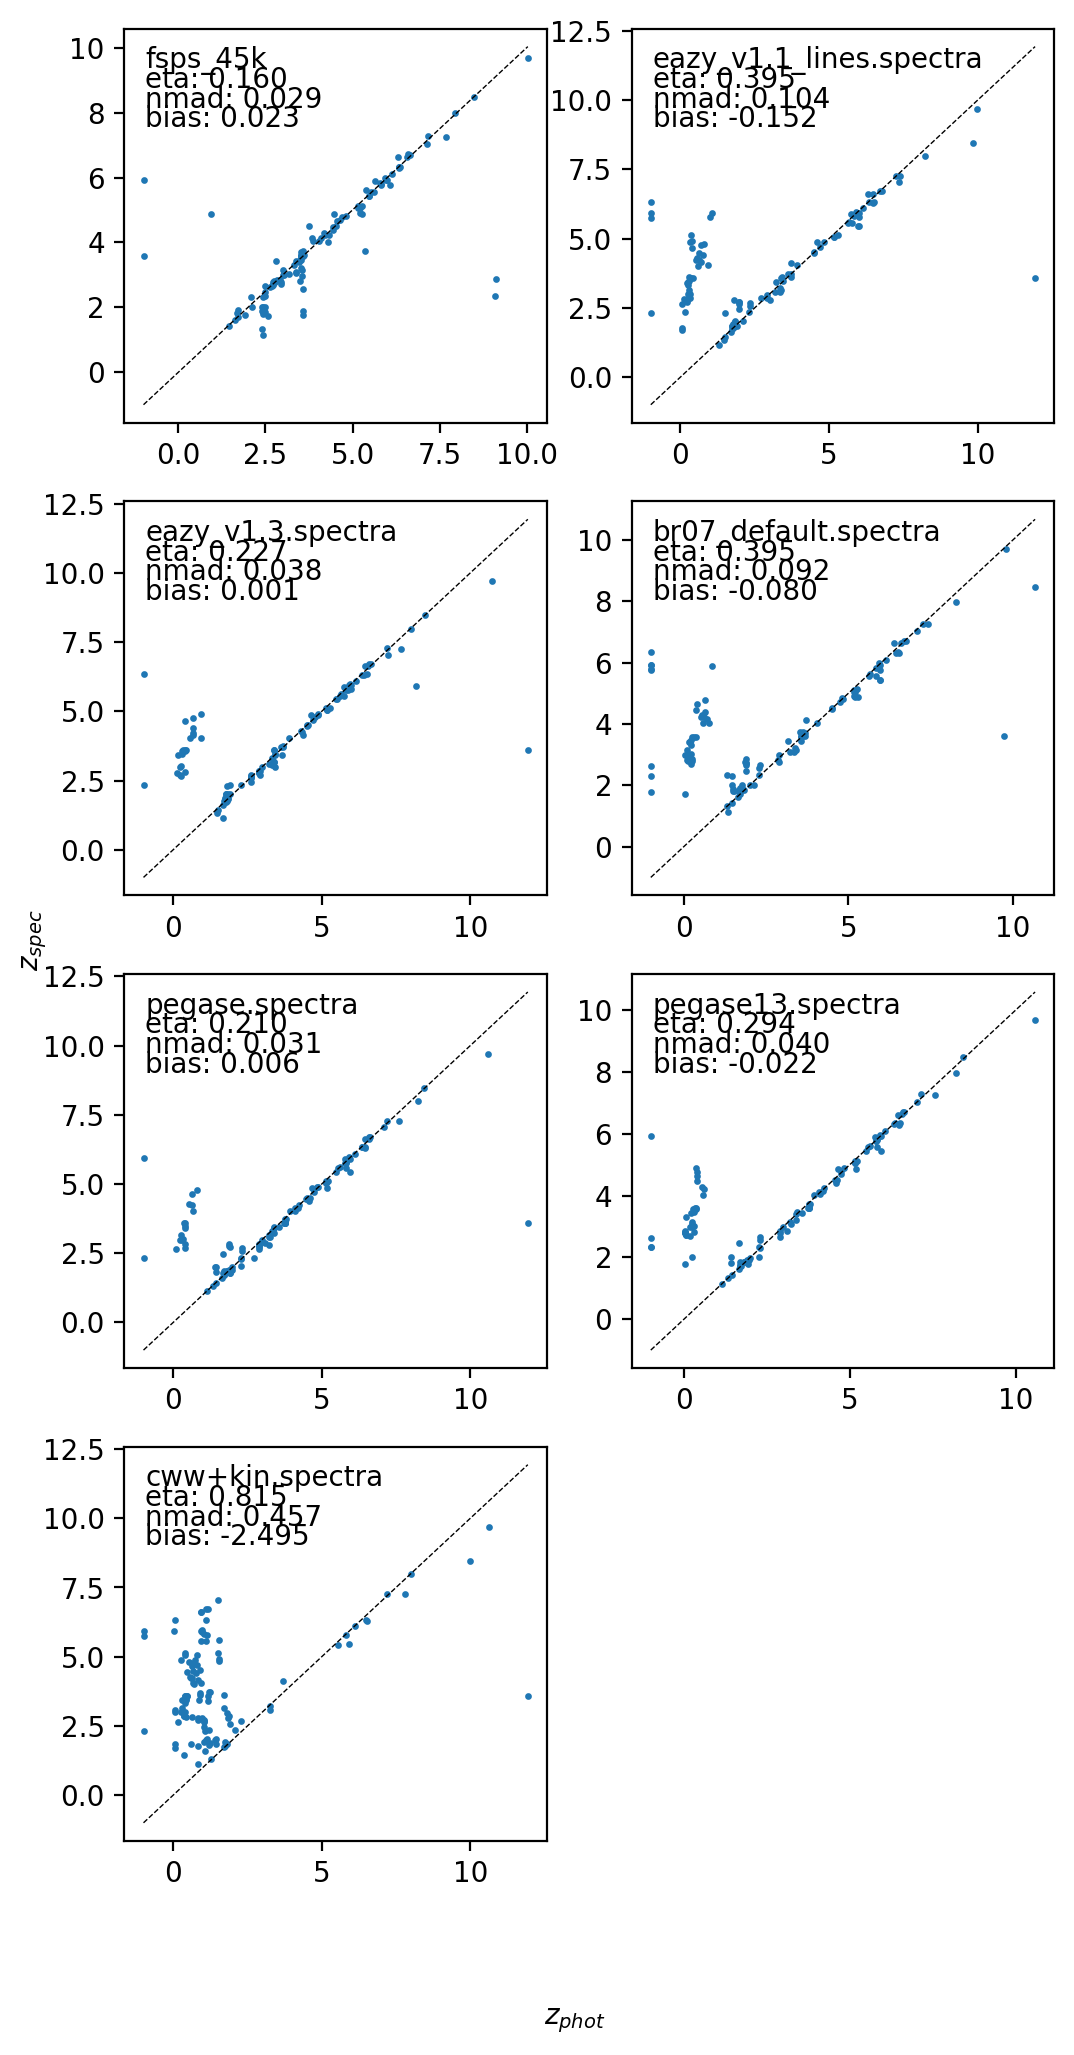

In [62]:
fpaths = 'eazy-output/{ftempl}_{runTime}/gds_jades_eazy.zout.fits'

mosaicLen = ceil(len(ftempl_strs) / 2)
figMos, axsMos = plt.subplots(mosaicLen, 2, figsize=(6, 3*mosaicLen), dpi=200)
axsMos = axsMos.flatten()

for i, ftempl in enumerate(ftempl_strs):

    fpath = fpaths.format(ftempl=ftempl, runTime=runTime)
    tbl = Table.read(fpath)
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    df_props = tbl[names].to_pandas()

    mask_cur = (df_props['z_spec'] > 0) & (~df_props['z_phot'].isna())
    x = df_props['z_phot'].values[mask_cur]
    y = df_props['z_spec'].values[mask_cur]

    xmin, xmax = np.c_[[x, y]].min(), np.c_[[x, y]].max()

    fig, ax = plt.subplots(1, figsize=(3, 3), dpi=200)
    ax.set_xlabel('$z_{phot}$')
    ax.set_ylabel('$z_{spec}$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)

    #ax.hexbin(x1, x2, gridsize=100, cmap='Greys', bins='log',
    #          mincnt=1, edgecolors='none', 
    #          extent=[xmin, xmax, xmin, xmax])
    ax.scatter(x, y, s=2.0)
    axsMos[i].scatter(x, y, s=2.0)
    ax.plot([xmin, xmax], [xmin, xmax], c='k', ls='--', lw=0.5)
    axsMos[i].plot([xmin, xmax], [xmin, xmax], c='k', ls='--', lw=0.5)
    
    dict_stat = hmod.phot_spec_zs_stats(y, x)
    ax.annotate(f'{ftempl}', (0.05, 0.9), xycoords='axes fraction')
    axsMos[i].annotate(f'{ftempl}', (0.05, 0.9), xycoords='axes fraction')
    for j, (k, val) in enumerate(dict_stat.items()):
        ax.annotate(f'{k}: {val:.3f}', (0.05, 0.85 - 0.05*j), 
                    xycoords='axes fraction', fontsize=10)
        axsMos[i].annotate(f'{k}: {val:.3f}', (0.05, 0.85 - 0.05*j),
                            xycoords='axes fraction', fontsize=10)
    
    fig.savefig(f'./docs/figures/{ftempl}.png', dpi=200, bbox_inches='tight')
    #fig.show()
    fig.clear()
    plt.close(fig)

if len(ftempl_strs) % 2 != 0:
    axsMos[-1].axis('off')

#axis label
figMos.text(0.5, 0.05, '$z_{phot}$', ha='center', va='center')
figMos.text(0.05, 0.5, '$z_{spec}$', ha='center', va='center', rotation='vertical')

figMos.savefig('./docs/figures/zs_mosaic.png', dpi=200, bbox_inches='tight')
figMos.show()

Load spectra:

In [63]:
#=== load EAZY outputs
fpath = os.path.join(out_paths[0], cat_name+'_fmt.zout.fits')
df = Table.read(fpath).to_pandas()

fname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
fpath = os.path.join(os.getenv('data'), 'gds/jades/phot', fname)
df_spec = Table.read(fpath, hdu=9)[['ID', 'EAZY_z_a', 'z_spec_source', 
                                    'z_spec_quality', 
                                    'z_spec_reference']].to_pandas()

# add spec info to the photo table
df = pd.merge(df, df_spec, on='ID', how='left')

#=== create masks
masks = {}
masks['z_spec'] = ~df['z_spec'].isna()

for i, (k, m) in enumerate(masks.items()):
    if isinstance(m, pd.Series):
        masks[k] = m.values

FileNotFoundError: [Errno 2] No such file or directory: 'eazy-output/fsps_45k_1689879183/gds_jades_eazy_fmt.zout.fits'

Redshift cross-check:

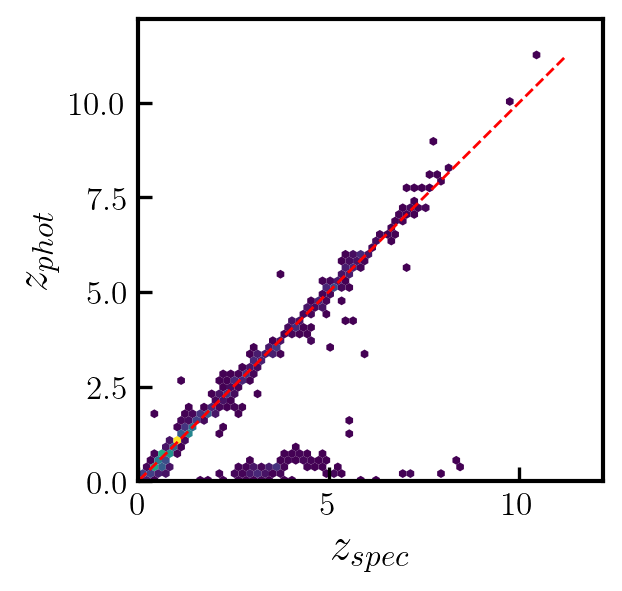

In [ ]:
mask_cur = masks['z_spec']

x = df['z_spec'].values[mask_cur]
y = df['z_phot'].values[mask_cur]

xmin, xmax = np.c_[x, y].min(), np.c_[x, y].max()
dx, dy = 0.2, 0.35

gridsize = (int((xmax-xmin)/dx), 
            int((xmax-xmin)/dy))

fig, ax = plt.subplots(1, figsize=(3, 3), dpi=200)
ax.set_xlabel('$z_{spec}$')
ax.set_ylabel('$z_{phot}$')
ax.set_xlim(0, 12.2)
ax.set_ylim(0.0, 12.2)

ax.hexbin(x, y, gridsize=gridsize,
          extent=(xmin, xmax, xmin, xmax), mincnt=1,
          edgecolors='none')
ax.plot([xmin, xmax], [xmin, xmax], ls='--', c='r', lw=1.0)
plt.show()

Plot spectra and best-fit SEDs:

In [ ]:
# load EAZY best-fit coefficients
fpath = 'eazy-output/corr_sfhz_13/gds_jades_eazy.data.fits'
with fits.open(fpath) as hdul:
    coeffs = hdul['COEFFS'].data
    print(hdul.info())

Filename: eazy-output/corr_sfhz_13/gds_jades_eazy.data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ZBEST         1 ImageHDU         7   (47181,)   float32   
  2  ZGRID         1 ImageHDU         7   (256,)   float32   
  3  CHI2          1 ImageHDU        10   (256, 47181)   float32   
  4  COEFFS        1 ImageHDU        23   (13, 47181)   float32   
None


In [ ]:
# catalog paths
cat_name = 'gds_jades_eazy'
cat_path = f'../data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template paths
templ_paths = ["templates/sfhz/corr_sfhz_13.param",
               "templates/sfhz/blue_sfhz_13.param",
               "templates/templates-c2020/45k/fsps_45k.param"]
out_names = [f.split('/')[-1].split('.')[0] for f in templ_paths]
out_paths = [f"eazy-output/{f}" for f in out_names]
paths = np.array([templ_paths, out_paths]).T

# iterate over tempalte sets
for tpath, opath in paths[:1]:
    
    params = {"cat_path": cat_path,
              "templ_path": tpath,
              "out_path": opath,
              "FIX_ZSPEC": 'n',
              "USE_ZSPEC_FOR_REST": 'n',
              "Z_MAX": 12.0,
              "H0": cosmo.H0,
              "OMEGA_M": cosmo.Om0,
              "OMEGA_L": cosmo.Ode0,
              "CATALOG_FORMAT": 'fits',
              'VERBOSE': 'n'}
    
    # write eazy config files
    filt_num, fnames = ez.write_config(cat_name, filts, zps, keys_id,
                                       out_path=opath, fwrite=False)
    
    # get a photoz object
    with io.capture_output() as captured: # capture output
        pz = ez.eazy_init_photoz(params, **fnames)

In [ ]:
# get best-fit redshifts and add to the catalog
tab_zbest = Table.from_pandas(df[['ID', 'z_phot']])
zbest = join(pz.cat[['ID']], tab_zbest, 
             keys='ID', join_type='left')

# get best-fit templates at zbest
#pz.fit_at_zbest(zbest=zbest)

Load RA & DEC of spectra. Then, match with the photometry catalog:

In [ ]:
from astropy.coordinates import SkyCoord

def match_catalogs(samp_x, samp_y, cat_x, cat_y, max_sep=1.0*u.arcsec):
    sample = SkyCoord(ra=samp_x*u.degree, dec=samp_y*u.degree)
    catalog = SkyCoord(ra=cat_x*u.degree, dec=cat_y*u.degree)
    idx, d2d, d3d = sample.match_to_catalog_sky(catalog)
    samp_sel = d2d < max_sep
    return samp_sel, idx

#=== load meta data from spec files
dname = "hlsp_jades_jwst_nirspec_goods-s-deephst_clear-prism_v1.0"
fpath = os.path.join(os.getenv('data'), 'gds/jades/spec', dname)

fnames_1d = [f for f in os.listdir(fpath) if '_x1d.fits' in f]
fpaths_1d = np.sort([os.path.join(fpath, f) for f in fnames_1d])

# get RA and DEC from the 1D spectra headers
df_spec = pd.DataFrame(columns=['ID', 'RA', 'DEC'], dtype=np.float32)
spec_data = {}
for f in fpaths_1d:
    id_fname = int(f.split('/')[-1].split('-')[3].strip('_clear'))
    with fits.open(f) as hdul:
        hdr = hdul[0].header
        row = np.array([id_fname, hdr['RA'], hdr['DEC']]).reshape(1, -1)
        df_cur = pd.DataFrame(row, columns=['ID', 'RA', 'DEC'])
        df_spec = pd.concat([df_spec, df_cur])
        
        
        unit = u.Unit(hdr['BUNIT']) # erg/s/cm2/A
        flux = hdul[1].data['FLUX'] * unit
        fluxerr = hdul[1].data['FLUX_ERR'] * unit
        wave = hdul[1].data['WAVELENGTH'] * u.um
        equiv = u.spectral_density(wave.to(u.AA))
        flux = flux.to(unit * u.AA / u.Hz, equivalencies=equiv)
        fluxerr = fluxerr.to(unit * u.AA / u.Hz, equivalencies=equiv)
        spec_data[id_fname] = [wave.value, 
                               flux.to(u.uJy).value, 
                               fluxerr.to(u.uJy).value]
        #spec_data[id_fname] = hdul[1].data['FLUX']
        

df_spec.reset_index(drop=True, inplace=True)
df_spec.ID = df_spec.ID.astype(np.int32)

#===match catalogs

# match spec sample to photo catalog
cat_x = df['ra'].values
cat_y = df['dec'].values
samp_x = df_spec['RA'].values
samp_y = df_spec['DEC'].values
mask_samp, idx_cat = match_catalogs(samp_x, samp_y, cat_x, cat_y, 
                                    max_sep=0.8*u.arcsec)

# add spec-flag column to catalog
df['ID_spec'] = np.nan
df.loc[idx_cat[mask_samp], 'ID_spec'] = df_spec.loc[mask_samp, 'ID'].values

In [ ]:
#=== rebin spectrum

from astropy import units as u

#x = wave
#y = flux_floor
#ye = flux_floor_err

def rebin_spec(x, y, ye, xlo=None, xhi=None, bw=1):
    """ 
    Rebin the spectrum to get higher SN
    """
    from spectres import spectres
    x_new = np.arange(xlo+bw, xhi, bw)
    y_new, ye_new = spectres(x_new, x, y, spec_errs=ye)
    return x_new, y_new, ye_new

def plot_binned_spec(x, y, ye, x_new, y_new, ye_new):
    
    axs = plt.figure(figsize=(5, 5), dpi=100).subplot_mosaic(
        """
        a
        b
        c
        """,
        gridspec_kw={
            "height_ratios": [3, 1, 1],
            "hspace": 0.0
        }
    )

    axs['a'].step(x, y, label='original') # original binning
    axs['a'].step(x_new, y_new, label='rebinned') # original binning
    axs['a'].set_ylabel('f')
    axs['a'].set_ylim(0.0, 0.05)
    axs['a'].set_xticklabels([])
    axs['a'].legend()
    axs['b'].step(x, y/ye)
    axs['b'].step(x_new, y_new / ye_new)
    axs['b'].set_ylabel('SNR')
    axs['b'].set_ylim(0.0, 10)
    axs['c'].step(x, ye)
    axs['c'].step(x_new, ye_new)
    axs['c'].set_ylabel('$\Delta$f')
    axs['c'].set_ylim(0.0, 0.05)

    plt.show()
    return 

#spaxel_lam_orig = (wave.max() - wave.min()) / 1024
#spaxel_lam_rbin = (wave.max() - wave.min()) / 1024 * bw
#print(f"original spectrum: 1 spaxel = {spaxel_lam_orig:.2f} A")
#print(f"rebinned spectrum: 1 spaxel = {spaxel_lam_rbin:.2f} A, bw={bw:.1f} A")

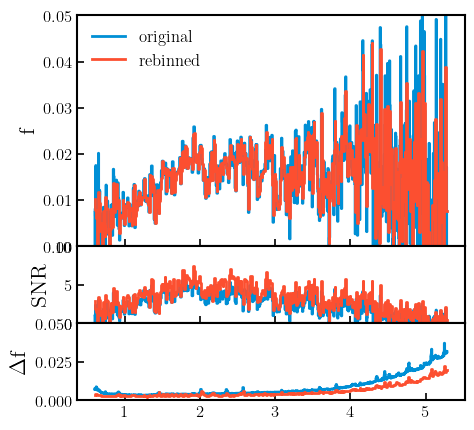

In [ ]:
x = spec_data[2332][0]
y = spec_data[2332][1]
ye = spec_data[2332][2]
xbin, ybin, yebin = rebin_spec(x, y, ye, xlo=x.min(), xhi=x.max(), bw=0.01)
plot_binned_spec(x, y, ye, xbin, ybin, yebin)

### Plot spectra and SEDs

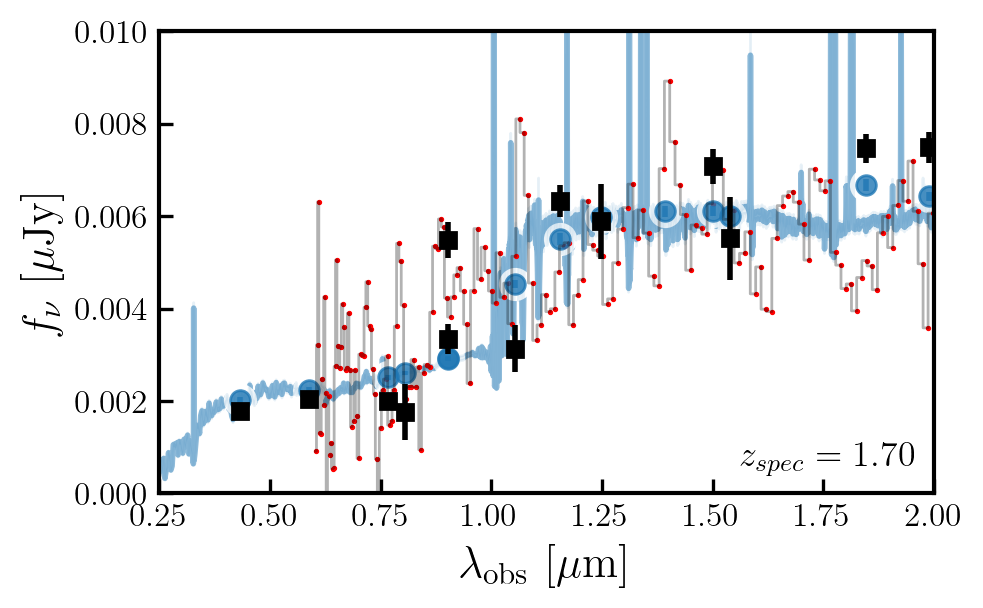

In [ ]:
# get spec for current obj
objid = 3803
x = spec_data[objid][0]
y = spec_data[objid][1]
ye = spec_data[objid][2]
xbin, ybin, yebin = x, y, ye
#xbin, ybin, yebin = rebin_spec(x, y, ye, xlo=x.min(), xhi=x.max(), bw=0.005)
id_cat = df['ID'][df['ID_spec'].isin([objid])].values

# get cur obj id and z
idx_cat = np.isin(zbest['ID'].data, id_cat)
z_obj = zbest['z_phot'][idx_cat][0]

#=== plot the data
fig, ax = plt.subplots(1, figsize=(5, 3), dpi=200)
ax.set_xlabel(r'$\lambda_{\rm obs}~[{\rm \mu m}]$')
ax.set_ylabel(r'$f_{\nu}~{\rm [\mu Jy]}$')
#ax.set_xlim(0.2, 6.0)
#ax.set_ylim(-0.001, 0.01)
ax.set_xlim(0.25, 2)
ax.set_ylim(0.000, 0.01)

fig, data = pz.show_fit(id=id_cat, add_label=True, axes=[ax],
                        show_components=False,
                        zshow=z_obj,
                        xlim=[0.1, 10.0], showpz=False, show_missing=True,
                        show_stars=False, snr_thresh=1.0,
                        show_fnu=True)#maglim=[])

ax.step(xbin, ybin/4, label='rebinned', lw=1, alpha=0.3, c='k')
ax.scatter(xbin, ybin/4, s=2.0, color='r', lw=0.5)

ax.annotate(rf"$z_{{spec}}={z_obj:.2f}$", xy=(0.75, 0.06), 
            xycoords='axes fraction')

plt.show()

### Compare photometry

In [ ]:
# catalog paths
cat_name = 'gds_jades_eazy'
cat_path = f'../data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template paths
out_names = [f.split('/')[-1].split('.')[0] for f in templ_paths]
out_paths = [f"eazy-output/{f}" for f in out_names]
paths = np.array(out_paths)

# iterate over tempalte sets
masses = {}
for i, opath in enumerate(out_paths):
    fn = out_names[i]
    fname = f"{cat_name}.zout.fits"
    fpath = os.path.join(opath, fname)
    mass = np.log10(Table.read(fpath)['mass'].data)
    masses[fn] = mass

/var/folders/48/5_9mwnxn3dn5y_3n2d7kg_t80000gn/T/ipykernel_2619/3285229757.py:17: RuntimeWarning: divide by zero encountered in log10
  mass = np.log10(Table.read(fpath)['mass'].data)
/var/folders/48/5_9mwnxn3dn5y_3n2d7kg_t80000gn/T/ipykernel_2619/3285229757.py:17: RuntimeWarning: invalid value encountered in log10
  mass = np.log10(Table.read(fpath)['mass'].data)


In [ ]:
mass

array([ 1.57234665e+05,  8.16907832e+06,  5.44552188e+08, ...,
       -9.00000000e+29,  4.25952810e+08,  3.11016980e+10])

In [ ]:
# plot individual SED components
templ = pz.templates[0]
templz = templ.wave*(1+z)

if pz.tempfilt.add_igm:
    igmz = templ.wave * 0.0 + 1
    lyman = templ.wave < 1300
    igmz[lyman] = IGM_OBJECT.full_IGM(z, templz[lyman])
else:
    igmz = 1.

for i in range(pz.NTEMP):
    if coeffs[i] != 0:
        pi = ax.plot(templz/1.e4, 
            coeffs_i[i]*tempflux[i,:]*igmz*fnu_factor*flam_spec, 
                    alpha=0.5, zorder=-1, 
                    label=pz.templates[i].name.split('.dat')[0], 
                    color=colors[i % len(colors)])


### Compare redshifts